In [1]:
#
#  ssne.py
#

import numpy as np
import pylab
import os
import matplotlib.pyplot as plt


def load_data(X_filename, label_filename):
    print('load data.....')
    print(X_filename[:-4])
    X_file = X_filename[:-4]
    label_file = label_filename[:-4]
    # exit()
    # Implement load data related codes here
    if os.path.exists(X_file + '.npy'):
        data = np.load(X_file + '.npy')
    else:
        data = np.loadtxt(X_filename, delimiter=',')
        np.save(X_file, data)

    if os.path.exists(label_file + '.npy'):
        label = np.load(label_file + '.npy')
    else:
        label = np.loadtxt(label_filename, delimiter=',')
        np.save(label_file, data)
    return data, label

In [2]:
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P

In [3]:
def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i + 1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i + 1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


In [4]:
def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")

    # Implement PCA here
    def mean(data):
        return np.mean(data, axis=1)

    def scatter_matrix(data):
        """ S = sum((Xk-m)@(Xk-m)^T) / n, where k=1,...,n """
        return np.cov(data, bias=True)

    def find_k_largest_eigenvalues(cov):
        k = no_dims
        eigen_value, eigen_vector = np.linalg.eig(cov)
        sorting_index = np.argsort(-eigen_value)
        eigen_value = eigen_value[sorting_index]
        eigen_vector = eigen_vector.T[sorting_index]
        return eigen_value[0:k], (eigen_vector[0:k])

    def transform(W, data):
        return W @ data

    data = X.T  # (784, 5000)
    ### mean ###
    mean = mean(data)  # (784,)
    print(mean.shape)
    ### S(covariance) ###
    S = scatter_matrix(data)  #(784, 784)
    print(S.shape)
    ### eigenvector & eigenvalue -> principle components ###
    eigen_value, eigen_vector = find_k_largest_eigenvalues(S)
    print('eigen_value:')
    print(eigen_value)
    print('eigen_vector:')
    print(eigen_vector.shape)
    ### Now W is eigen_vector (no_dims, 784) ###
    transformed_data = np.real(transform(eigen_vector, data))
    # np.savetxt('transformed.txt', np.imag(transformed_data))
    print('transformed: ', transformed_data.shape)
    print(transformed_data)
    return transformed_data.T

In [57]:
def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 50
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    '''
    P = P * 4.  # early exaggeration
    '''
    P = P * 2.  # early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        # num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num = np.exp(-1 * np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            '''
            dY[i, :] = np.sum(
                np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y),
                0)
            '''
            dY[i, :] = np.sum(
                np.tile(PQ[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

In [46]:
def similarity_dist(D, n_bins=50):
    D = np.array(D)
    bins = [[] for i in range(n_bins)]

    thresholds = [
        np.min(D) + i / n_bins * (np.max(D) - np.min(D))
        for i in range(n_bins + 1)
    ]
    
    for i in range(1, n_bins + 1):
        bins[i - 1] = D[(D <= thresholds[i]) & (D > thresholds[i - 1])].shape[0]

    return np.array(bins) / 2, thresholds[0:-1]

In [49]:
def compute_pairwise_dist(n, Y):
    # Compute pairwise affinities
    sum_Y = np.sum(np.square(Y), 1)
    num = -2. * np.dot(Y, Y.T)
    # num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
    #num = np.exp(-1 * np.add(np.add(num, sum_Y).T, sum_Y))
    num = np.add(np.add(num, sum_Y).T, sum_Y)
    num[range(n), range(n)] = 0.
#     Q = num / np.sum(num)
#     Q = np.maximum(Q, 1e-12)
#     return dist
    Q = num
    return Q
    

In [61]:
if __name__ == "__main__":
    print(
        "Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset."
    )
    print("Running example on 2,500 MNIST digits...")
    X, labels = load_data('mnist_X.csv', 'mnist_label.csv')
    Y = tsne(X, 10, 50, 20.0)
    # pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
    # pylab.show()

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
load data.....
mnist_X
Preprocessing the data using PCA...
(784,)
(784, 784)
eigen_value:
[8.04918878+0.j 4.44770058+0.j 3.43525144+0.j 3.26278806+0.j
 2.7804046 +0.j 2.11013737+0.j 1.84025522+0.j 1.44765374+0.j
 1.38812259+0.j 1.193162  +0.j 1.08883714+0.j 0.9327465 +0.j
 0.8807986 +0.j 0.81231805+0.j 0.77625515+0.j 0.69386989+0.j
 0.66941876+0.j 0.61742183+0.j 0.59542722+0.j 0.56244567+0.j
 0.5001472 +0.j 0.47957136+0.j 0.47019905+0.j 0.43778355+0.j
 0.43040579+0.j 0.40567031+0.j 0.38055975+0.j 0.37081285+0.j
 0.35461363+0.j 0.33713058+0.j 0.32477788+0.j 0.3122558 +0.j
 0.28073759+0.j 0.27471868+0.j 0.26338429+0.j 0.25775301+0.j
 0.25108304+0.j 0.23922053+0.j 0.22587304+0.j 0.22497242+0.j
 0.20663082+0.j 0.20563794+0.j 0.20245611+0.j 0.1906108 +0.j
 0.18846049+0.j 0.18480074+0.j 0.17821267+0.j 0.17403797+0.j
 0.17135392+0.j 0.15805769+0.j]
eigen_vector:
(50, 784)
trans

In [62]:
    n_bins = 50
    D = compute_pairwise_dist(X.shape[0], Y)
    print(D)
    bins, x = similarity_dist(D, n_bins)

[[ 0.          0.71994341  8.72450176 ... 22.21897036 25.33885788
  25.07050675]
 [ 0.71994341  0.          9.89930449 ... 23.14418631 25.3429442
  26.94421884]
 [ 8.72450176  9.89930449  0.         ... 14.65793974 22.5978014
  11.72916309]
 ...
 [22.21897036 23.14418631 14.65793974 ...  0.          9.31734086
  11.45243586]
 [25.33885788 25.3429442  22.5978014  ...  9.31734086  0.
   9.86791131]
 [25.07050675 26.94421884 11.72916309 ... 11.45243586  9.86791131
   0.        ]]


[[-1.12567914  1.72095864  1.02255444 ...  0.3071813  -1.21463718
  -0.30075301]
 [-0.98770903  1.92668469  0.63807095 ...  0.36042902 -1.2291246
   0.09828739]
 [-0.64381642  1.02119199  2.10307262 ...  0.56385992  0.17560201
   0.18665406]
 ...
 [ 0.36508844 -0.43799679 -0.07570842 ... -0.20832422 -1.02653505
   0.31077451]
 [ 0.71643004 -0.73600679 -0.39054247 ... -0.72582998 -0.27753993
  -0.22292421]
 [ 0.33246033 -0.59229614  1.77532044 ... -0.89996539  0.46010621
  -1.1333806 ]]


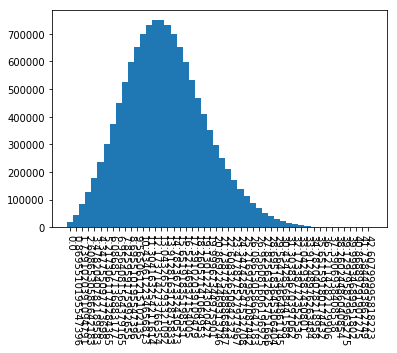

In [63]:
    
    figure = plt.figure()
    ax = figure.add_subplot(111)
    x = np.array(x)
    x[x < 0] = 0
    print(Y)
    ax.bar(range(n_bins), bins, width=1, tick_label=x)

    plt.xticks(rotation=-90)
    plt.show()